original data: [MIMIC-III](https://physionet.org/content/mimiciii/1.4/)  
cleaned data from : [kaggle](https://www.kaggle.com/datasets/saurabhshahane/in-hospital-mortality-prediction) <br> more details in [here](https://datadryad.org/stash/dataset/doi:10.5061/dryad.0p2ngf1zd) 

Goal: 중환자실에 입원해있는 심부전 환자들의 생존율을 높인다.

Questions: 
- 생존과 관련된 징후에는 어떤 것이 있는가?
- 어떻게 연관되어있는가?
- 생존율을 높이기 위해선 어떤 조치를 취해야하는가?

조사 대상
- 18세 이상 환자
- 중환자실 기록, LVEF, NT-proBNP 기록이 존재하는 환자로  

사용한 데이터에서는 총 ICD-9에 있는 13389개의 환자 기록 중 위 조건을 만족하는 환자 1177개만 추출했다.

# Metadata

|  | 인구통계학적 특성 |  |
|-----|-------------------------|---|
| Age | 병원에 입원했을 때 나이 |  |
| Sex | 성별                    |  |
| BMI | 체질량 지수             | kg/m^2

<br>

|   중복이환           |        0: False 1: True          |
|---------------------|----------------------------------|
| Hypertension        | 고혈압                           | 
| Atrial Fibrillation | 심방 세동                        |
| CHD with no MI      | 선천적 심장병 없이 심근경색 발생 |
| Diabetes Mellitus   | 당뇨                             |
| Depression          | 우울증                           |
| Deficiency Anemias  | 철결핍빈혈                       |
| Hyperlipidemia      | 고지혈증                         |
| Renal failure       | 신부전                           |
| COPD                | 만성폐쇄성폐질환                 |

<br>

| 활력 징후(Vital Signs)        | 입원 시 최초 24시간동안 측정 | 단위 |
|-------------------------------|------------------------------|------|
| Heart Rate(HR)                | 심박수                       | bpm  |
| SBP (Systolic Blood Pressure)  | 수축기 혈압                  | mmHg |
| DBP (Diastolic Blood Pressure) | 이완기 혈압                  | mmHg |
| Respiratory Rate              | 분당 호흡 수                 | bpm  |
| Temperature                   | 체온                         | C    |
| SPO2 (Saturation Pulse Oxygen) | 혈중 산소 포화도             | %    |
| urine output                  | 소변 배출량                  | mL   |

<br>

| 임상병리 변수(Laboratory Variables)               | 혈액 내                          | 단위          |
|-------------------------------------------------|----------------------------------|---------------|
| Hematocrit                                      | 적혈구 용적률                    | %             |
| RBC (Red Blood Cells)                            | 적혈구 수                        | million/uL    |
| MCH (Mean Corpuscular Hemoglobin)                | 평균 적혈구 혈색소량             | pg            |
| MCHC (Mean Corpuscular Hemoglobin Concentration) | 평균 적혈구 혈색소 농도          | %             |
| MCV (Mean Corpuscular Volume)                    | 평균 적혈구 용적                 | fL            |
| RDW (Red Blood Cell Distribution Width)          | 적혈구 크기 분포                 | %             |
| Leucocyte                                       | 백혈구                           | thousand / mL |
| Platelets                                       | 혈소판                           | thousand / mL |
| Neutrophils                                     | 호중구                           | %             |
| Basophils                                       | 호염기구                         | %             |
| Lymphocyte                                      | 림프구                           | %             |
| PT (Prothrombin Time)                            | 프로트롬빈 시간                  | s             |
| INR (International Normalized Ratio)             | PT를 국제적으로 표준화한 단위    |               |
| NT-proBNP                                       | N 말단 뇌성 나트륨 이뇨 펩타이드 | pg/mL         |
| Creatine Kinase                                 | 크레아틴 키나제                  | U/L           |
| Creatinine                                      | 크레아티닌                       | mg/dL         |
| BUN (Blood Urea Nitrogen)                        | 혈액 요소 질소                   | mg/dL         |
| Glucose                                         | 포도당                           | mg/dL         |
| Potassium                                       | 포타슘                           | mEq/L         |
| Sodium                                          | 소듐                             | mEq/L         |
| Calcium                                         | 칼슘                             | mmol/L        |
| Chloride                                        | 염화이온                         | mEq/L         |
| Anion gap                                       | 음이온차                         | mEq/L         |
| Magnesium ion                                   | 마그네슘 이온                    | mg/dL         |
| pH                                              | 수소 이온 농도 지수              |               |
| Bicarbonate                                     | 탄산수소염                       | mEq/L         |
| Lactate acid                                    | 락트산                           | mmol/L        |
| PCO2                                            | 동맥혈 탄산 가스 분압            | mmHg          |
| LVEF (Left Ventricular Ejection Fraction)        | 좌심실 박출률                    | %             |

- `outcome`: 생존 여부 / 0: 생존, 1: 사망

특성별로 EDA할때 normal range 추가하기, 어떤 영향을 주는건지 설명 추가, LVEF는 직접적인 영향을 줄거같은데 drop 해야하나? 다 돌려보기

# Import and Load

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

import lightgbm as lgbm
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./data/In_hospital_mortality_prediction.csv')

In [3]:
df.sample(5)

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
665,1,141609,1.0,80,1,24.992482,1,0,0,0,0,0,0,0,0,62.947368,104.789474,24.736842,23.640000,36.156250,97.368421,160.0,42.980000,4.882000,30.820000,35.000000,88.200000,13.740000,18.460000,78.400000,89.100000,0.10,8.60,20.460000,1.900000,773.0,433.000000,1.800000,25.600000,169.333333,5.525000,141.000,7.575000,108.750000,23.500000,2.125000,7.25875,14.500000,6.166667,33.714286,55
436,1,105918,0.0,87,1,NaN,1,1,0,0,0,0,0,0,0,61.000000,112.818182,41.272727,17.541667,37.342593,97.750000,1407.0,31.025000,4.100000,23.250000,30.725000,75.750000,15.500000,11.100000,185.500000,93.650000,0.20,2.50,33.550000,3.250000,1131.0,NaN,1.025000,19.000000,189.000000,3.725000,136.500,8.350000,100.500000,13.500000,2.250000,7.45000,26.500000,1.900000,40.000000,55
962,2,118689,0.0,71,1,26.743227,1,0,0,0,1,0,0,1,0,83.034483,98.653061,63.204082,21.558824,36.398148,98.441176,2265.0,30.955556,3.804444,25.111111,30.877778,81.555556,16.366667,9.511111,364.222222,92.550000,0.40,4.75,14.987500,1.312500,42615.0,248.000000,2.584615,60.416667,114.500000,5.153846,136.000,8.027273,100.833333,14.583333,2.107692,7.31000,25.750000,1.650000,39.333333,20
1166,2,174899,0.0,78,1,23.296976,0,0,0,0,0,0,0,0,0,91.700000,139.368421,80.368421,22.350000,36.407407,95.100000,3470.0,38.362500,3.693750,36.187500,34.837500,104.000000,14.337500,7.425000,183.000000,88.000000,NaN,6.60,13.450000,1.185714,30156.0,28.333333,1.262500,27.375000,88.000000,4.137500,138.625,8.085714,106.000000,13.750000,1.987500,NaN,23.125000,NaN,NaN,55
707,1,194431,0.0,72,1,31.962834,1,1,0,0,1,1,1,0,1,80.000000,129.304348,70.521739,17.680000,36.537037,91.520000,2670.0,36.110000,4.087500,28.900000,32.850000,88.125000,14.262500,18.012500,378.125000,93.333333,0.15,4.65,13.533333,1.166667,1927.0,252.500000,1.027273,18.090909,191.000000,3.933333,142.000,9.240000,101.272727,14.636364,2.150000,7.44000,30.363636,NaN,40.000000,35


In [4]:
df[df['outcome'].isna()]

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
1159,2,162338,NaN,83,1,NaN,1,0,0,1,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.9125,3.9375,29.7,32.5625,91.375,15.1,8.25,226.0,78.0,0.3,12.55,11.3,0.933333,14649.5,82.4,4.2125,42.0,NaN,4.4375,130.666667,7.45,92.625,15.5,1.983333,NaN,26.5,NaN,NaN,55


In [5]:
df.columns

Index(['group', 'ID', 'outcome', 'age', 'gendera', 'BMI', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF'],
      dtype='object')

1177개의 데이터 중 30%(group 2, n=352)는 모델 성능을 확인하기 위한 테스트 데이터로 분리한다.  
데이터 중 타겟이 결측치인 경우가 있다. 이 데이터는 모델이 맞췄는지 알 수 없기 때문에 삭제해준다.

In [6]:
df = df[df['outcome'].notna()]

train = df.query("group==1")
test = df.query("group==2")

# Preprocessing

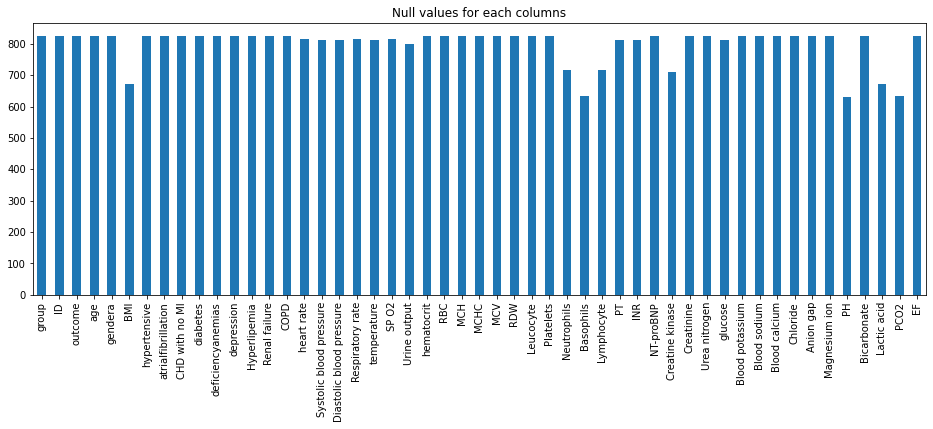

In [7]:
train.notna().sum().plot(kind='bar', figsize=(16, 5))
plt.title("Null values for each columns")
plt.show()

In [8]:
col_w_nulls = train.columns[train.isna().any()].values

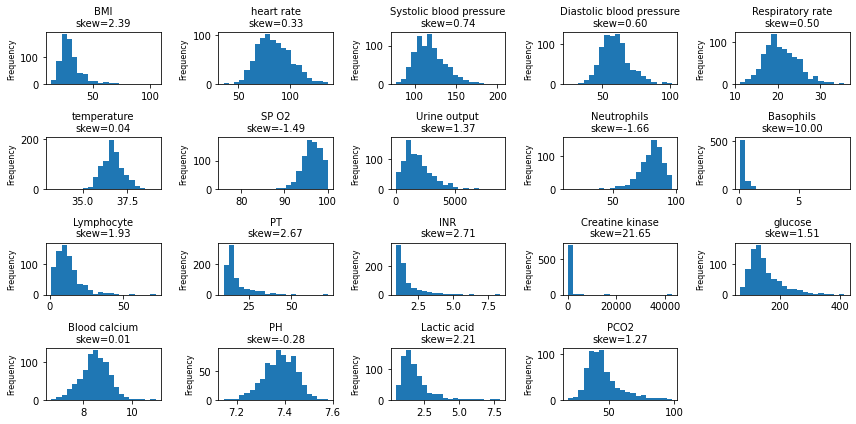

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(12, 6))
for col, ax in zip(col_w_nulls, axes.ravel()):
    train[col].plot(kind='hist', bins=20, ax=ax)
    ax.set_title(f"{col}\nskew={train[col].skew():.2f}", fontsize=10)
    ax.set_ylabel('Frequency', fontsize=8)
    
axes[-1, -1].axis('off')
plt.tight_layout()
plt.show()

전체 특성 중 결측치를 가지는 특성의 분포를 확인했다.

전체 데이터중 훈련 데이터로 사용할 그룹(1)을 기준으로 결측치 처리를 해주었다. Skewness로 정규분포를 따르는지 확인해 정규분포 형태를 띄는 연속형 변수는 특성의 변수로 바꾸어주고, 불균형한 연속형 데이터의 경우에는 중앙값으로 결측치를 보완해준다.  

크레아틴키나제(Creatine kinase, CK)는 skewness가 21.65로 매우 큰 이상치가 있어 확인이 필요해보인다.  
CK는 심장, 뇌, 골격근 등에서 발견되는 효소로 정상 범위는 20\~380까지이다. 
혈액의 CK는 대부분 근육에서 온 것으로 운동이나 부상으로 인해 수치가 높아지며 신장에 이상이 있거나 횡경막 융해증의 경우 10K\~200K까지 올라가는 경우도 있다([Case report](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5507674/)).
따라서 이 이상치는 제거하지 않는다.

호염기구(Basophils)의 skewness도 10으로 이상치 확인이 필요해보인다.  
호염기구는 건강한 성인의 경우 백혈구의 0.5에서 1%를 차지하지만 현재 사용하는 데이터가 중환자실 환자이므로 높게 나오는 경우가 있다. 알러지, 감염, 염증에 의해서도 증가한다.
데이터셋에서는 최대 8% 까지 있다. 7.1% 인 환자는 중복이환으로 타당해 보인다. 8% 인 환자도 데이터에 포함되지 않은 증상이 있을 수 있으므로 제거하지 않는다. 만성골수성백혈병의 경우에는 20% 이상으로 측정된다([Extreme case report](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6256821/)).

나머지 특성들은 skewness의 크기 1을 기준으로 1보다 낮으면 평균, 1보다 높으면 중앙값으로 결측치를 보완한다.  
트리 기반 모델(XGBoost, LightGBM)을 사용할 경우 결측치는 보완하지 않고 사용할 예정이다.

## Preprocessing

In [10]:
skewed = train[col_w_nulls].columns[train[col_w_nulls].skew().abs() > 1].values
not_skewed = train[col_w_nulls].columns[train[col_w_nulls].skew().abs() < 1].values

def preprocessing(df_train, df_test, target_impute=False):
    df_train = df_train.drop(['group', 'ID'], axis=1)
    df_test = df_test.drop(['group', 'ID'], axis=1)
    
    if target_impute:
        skewed_median = df_train.groupby('outcome')[skewed].median()
        not_skewed_mean = df_train.groupby('outcome')[not_skewed].mean()
        
        for s, impute in zip([skewed, not_skewed], [skewed_median, not_skewed_mean]):
            df_train.loc[df_train['outcome']==0, s] = (df_train.loc[df_train['outcome']==0, s]
                                                      .fillna(impute.iloc[0]))
            df_train.loc[df_train['outcome']==1, s] = (df_train.loc[df_train['outcome']==1, s]
                                                      .fillna(impute.iloc[1]))
            df_test.loc[:, s] = df_test.loc[:, s].fillna(impute.mean())
        
    else:
        skewed_imputer = SimpleImputer(strategy='median')
        not_skewed_imputer = SimpleImputer(strategy='mean')
        
        df_train[skewed] = skewed_imputer.fit_transform(df_train[skewed])
        df_test[skewed] = skewed_imputer.transform(df_test[skewed])
        
        df_train[not_skewed] = not_skewed_imputer.fit_transform(df_train[not_skewed])
        df_test[not_skewed] = not_skewed_imputer.transform(df_test[not_skewed])
        
    return df_train, df_test

In [11]:
train_prc, test_prc = preprocessing(train, test)

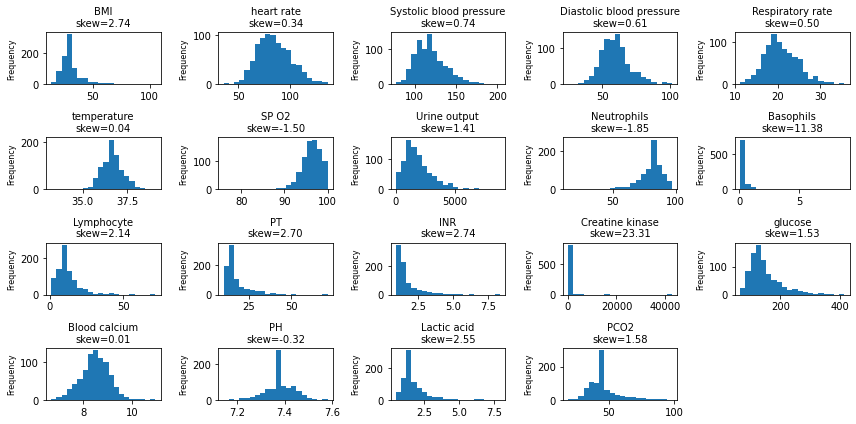

In [12]:
fig, axes = plt.subplots(4, 5, figsize=(12, 6))
for col, ax in zip(col_w_nulls, axes.ravel()):
    train_prc[col].plot(kind='hist', bins=20, ax=ax)
    ax.set_title(f"{col}\nskew={train_prc[col].skew():.2f}", fontsize=10)
    ax.set_ylabel('Frequency', fontsize=8)
    
axes[-1, -1].axis('off')
plt.tight_layout()
plt.show()

결측치를 모두 평균이나 중앙값으로 대체했기 때문에 그 값의 분포가 평균이나 중앙값에 몰려있는 경우가 발생했다.

# EDA

## Comorbidities

### $H_0$: 다른 병이 있는 경우 사망률이 높을 것이다.

In [13]:
comorbidities = [col for col in train_prc.columns if train_prc[col].dtype=='int64' and col not in ['age', 'gendera', 'EF']]

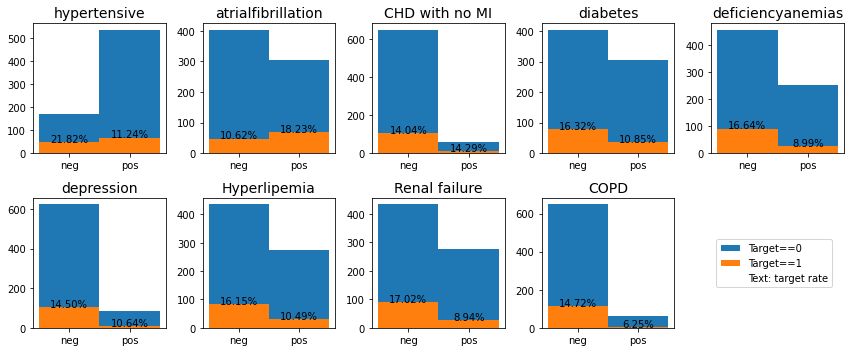

In [14]:
from matplotlib.patches import Patch

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.ravel()):
    if i==9:
        break
    temp_neg = train[train['outcome']==0][comorbidities[i]]
    temp_pos = train[train['outcome']==1][comorbidities[i]]
    
    counts_neg, bins_neg = np.histogram(temp_neg, bins=2)
    counts_pos, bins_pos = np.histogram(temp_pos, bins=2)
    
    n, bins, patches = ax.hist(temp_neg, bins=bins_neg)
    ax.hist(temp_pos, bins=bins_pos)
    
    ticks = [patch._x0+0.25 for patch in patches]
    ticklabels = ['neg', 'pos']
    ax.set_xticks(ticks, ticklabels)

    for j in range(2):
        temp = train[train[comorbidities[i]]==j]['outcome']
        ax.text(ticks[j], temp_pos.value_counts()[j].sum(),
                f"{temp.mean()*100:.2f}%",
                ha='center')
        
    ax.set_title(comorbidities[i], fontsize=14)
    
legend_elements = [Patch(facecolor='tab:blue', edgecolor='w',
                         label='Target==0'),
                   Patch(facecolor='tab:orange', edgecolor='w',
                         label='Target==1'),
                   Patch(facecolor='w', edgecolor='w',
                         label='Text: target rate')]
axes[-1, -1].axis('off')
axes[-1, -1].legend(handles=legend_elements, loc='center left')

plt.tight_layout()
plt.show()

### T-test

In [15]:
# Only Train data
for col in comorbidities:
    t, pvalue = stats.ttest_ind(train_prc[train_prc['outcome']==0][col],
                                train_prc[train_prc['outcome']==1][col])
    print(f"{col:19s}: {pvalue:.3f}")

hypertensive       : 0.000
atrialfibrillation : 0.002
CHD with no MI     : 0.955
diabetes           : 0.026
deficiencyanemias  : 0.003
depression         : 0.311
Hyperlipemia       : 0.024
Renal failure      : 0.001
COPD               : 0.061


In [16]:
# Overall
for col in comorbidities:
    t, pvalue = stats.ttest_ind(df[df['outcome']==0][col], df[df['outcome']==1][col])
    print(f"{col:19s}: {pvalue:.3f}")

hypertensive       : 0.013
atrialfibrillation : 0.001
CHD with no MI     : 0.615
diabetes           : 0.087
deficiencyanemias  : 0.001
depression         : 0.037
Hyperlipemia       : 0.067
Renal failure      : 0.000
COPD               : 0.105


다른 병을 앓고 있는 경우(neg, pos) 중환자실에서 사망(blue: alive, orange: dead) 비율(%)을 확인한 그래프다. 다른 병이 있더라도 사망 여부와는 크게 상관 없어보인다. 반대로 병이 없을 경우에 사망 비율이 더 높게 나타났다.

---

## Vital Signs

### $H_0$: 활력 징후들이 정상 수치를 벗어나면 사망률이 높아질 것이다.
정상 범위
- Heart Rate, 심박수: 60 ~ 100 bpm
- SBP, 수축기 혈압: 90 ~ 120 mmHg
- DBP, 이완기 혈압: 60 ~ 80 mmHg
- Respiratory Rate, 분당 호흡 수: 12 ~ 20 breaths per min
- Temperature: 체온: 36.5 ~ 37.3 C
- SPO$_2$ 혈중 산소 포화도: 95 ~ 100 %
- Urine output: 소변 배출량: 800 ~ 2000 mL

reference 1: [Cleveland Clinic](https://my.clevelandclinic.org/)  
reference 2: [UCSF Health](https://www.ucsfhealth.org/)

In [17]:
vs = list(train_prc.columns[13:20])

In [18]:
vs_normal = {'heart rate': [60, 100],
             'Systolic blood pressure': [90, 120],
             'Diastolic blood pressure': [60, 80],
             'Respiratory rate': [12, 20],
             'temperature': [36.5, 37.3],
             'SP O2': [95, 100],
             'Urine output': [800, 2000]}

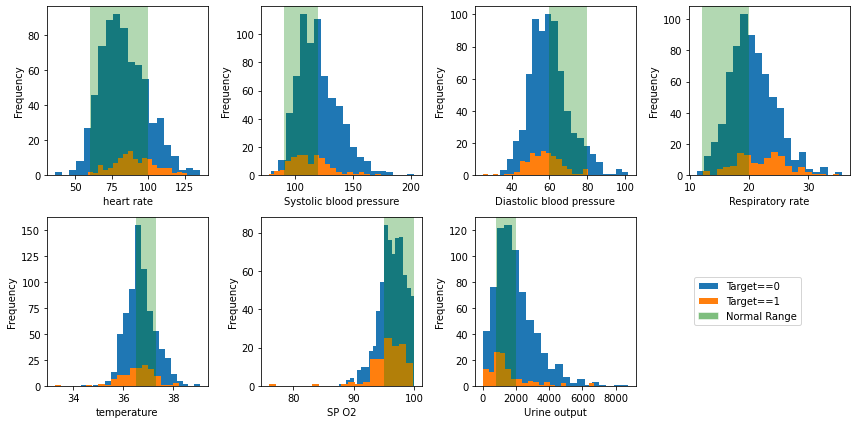

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for col, ax in zip(vs, axes.ravel()):
    train_prc.query("outcome==0")[col].plot(kind='hist', bins=20, ax=ax)
    train_prc.query("outcome==1")[col].plot(kind='hist', bins=20, ax=ax)
    ax.axvspan(*vs_normal[col], facecolor='green', alpha=0.3)
    ax.set_xlabel(col)
    
legend_elements = [Patch(facecolor='tab:blue', edgecolor='w',
                         label='Target==0'),
                   Patch(facecolor='tab:orange', edgecolor='w',
                         label='Target==1'),
                   Patch(facecolor='g', edgecolor='w', alpha=0.5,
                         label='Normal Range')]
axes[-1, -1].axis('off')
axes[-1, -1].legend(handles=legend_elements, loc='center left')

plt.tight_layout()
plt.show()

### T-test

In [20]:
# Only Train data
for col in vs:
    t, pvalue = stats.ttest_ind(train_prc[train_prc['outcome']==0][col],
                                train_prc[train_prc['outcome']==1][col])
    print(f"{col:25s}: {pvalue:.3f}")

heart rate               : 0.000
Systolic blood pressure  : 0.000
Diastolic blood pressure : 0.005
Respiratory rate         : 0.000
temperature              : 0.016
SP O2                    : 0.013
Urine output             : 0.000
